In [1]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.getcwd())
from my_udfs import *


C:\Users\GottaGoFaster\Documents\Python_Code_Showcase\Project_Showcase


# Data Import

In [2]:
# Load datasets
# Replace with the actual paths to your data files
dispatch_data = pd.read_csv('data/dispatch_data_with_issues.csv')
weather_data = pd.read_csv('data/weather_data_with_issues.csv')
traffic_data = pd.read_csv('data/traffic_data_with_issues.csv')

print(dispatch_data.shape)
print(weather_data.shape)
print(traffic_data.shape)

(500, 4)
(450, 4)
(400, 3)


In [3]:
# Display basic info
print("Dispatch Data Info:")
print(dispatch_data.info())
print("\nWeather Data Info:")
print(weather_data.info())
print("\nTraffic Data Info:")
print(traffic_data.info())


Dispatch Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dispatch_id    500 non-null    int64 
 1   location_id    500 non-null    int64 
 2   job_type       489 non-null    object
 3   dispatch_time  500 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.8+ KB
None

Weather Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_id    450 non-null    int64  
 1   date           450 non-null    object 
 2   temperature    439 non-null    float64
 3   precipitation  450 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 14.2+ KB
None

Traffic Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (

In [4]:
# Preview data
print("\nDispatch Data Preview:")
print(dispatch_data.head())
print("\nWeather Data Preview:")
print(weather_data.head())
print("\nTraffic Data Preview:")
print(traffic_data.head())



Dispatch Data Preview:
   dispatch_id  location_id       job_type                  dispatch_time
0            1          106  fuel_delivery  2024-01-02 08:47:37.867155968
1            2          106  fuel_delivery  2024-01-03 23:29:39.787000320
2            3          112    tire_change  2024-01-03 11:09:58.744973312
3            4          113   battery_jump  2024-01-01 12:23:25.783618048
4            5          111        lockout  2024-01-01 15:50:39.269447424

Weather Data Preview:
   location_id                 date  temperature  precipitation
0          106  2024-01-01 00:00:00         72.3           1.85
1          112  2024-01-02 00:00:00         90.3           0.96
2          111  2024-01-03 00:00:00         72.2           4.50
3          116  2024-01-03 00:00:00         71.4           3.21
4          115  2024-01-01 00:00:00         74.7           0.00

Traffic Data Preview:
   location_id                 date traffic_level
0          104  2024-01-01 00:00:00          high
1 

# EDA by dataset

In [5]:
# Dispatch data EDA

# Known valid job types
valid_job_types = ["towing", "fuel_delivery", "battery_jump", "lockout", "tire_change"]

# Look for any duplicates and distribution of uniques
print(dispatch_data['dispatch_id'].value_counts().reset_index(name = 'count').sort_values('count', ascending = False)) # Good, dispatch_id is unique, no duplicates
# View uniques and distribution of location_id column
print(dispatch_data['dispatch_time'].value_counts().reset_index(name = 'count').sort_values('count', ascending = False))  # dispatch_time is unique, no duplicates

# Look at uniques of my categorical columns
view_cat_uniques(dispatch_data, ["job_type","location_id"])
# job_type: Fairly even split across the 5 values, with towing at the lowest frequency and lockout at the top
# location_id: Looks like 16 unique values, but 1 odd 9999. Will probably have to clean that out. 104 also has lowest representation (less than 1/2 of 103)

print("-"*50)


# Missing Values in All Columns
print("Missing values across columns:")
print(dispatch_data.isnull().sum())
print("-"*50)

# Invalid or Missing Job Types
#   a) Missing (NaN)
missing_job_types = dispatch_data[dispatch_data['job_type'].isnull()]
#   b) Not in valid list (and not null)
invalid_job_types = dispatch_data[~dispatch_data['job_type'].isin(valid_job_types) & 
                                  dispatch_data['job_type'].notnull()]

print("Invalid or missing job_type rows:")
if not missing_job_types.empty:
    print("\n- Missing job_type rows:")
    print(missing_job_types)
if not invalid_job_types.empty:
    print("\n- job_type not in valid list:")
    print(invalid_job_types)
if missing_job_types.empty and invalid_job_types.empty:
    print("No invalid or missing job_type rows found.")
print("-"*50)

# Invalid location IDs (e.g., not between 101 and 116)
invalid_location_ids = dispatch_data[~dispatch_data['location_id'].between(101, 116)]
print("Invalid location_id rows:")
if invalid_location_ids.empty:
    print("No invalid location_id rows found.")
else:
    print(invalid_location_ids)
print("-"*50)

# Invalid dispatch_time (non-parsable or missing)
#   We'll coerce errors to NaT; rows where dispatch_time = NaT are invalid
dispatch_data['parsed_time'] = pd.to_datetime(dispatch_data['dispatch_time'], errors='coerce')
invalid_dispatch_time = dispatch_data[dispatch_data['parsed_time'].isnull()]

print("Invalid dispatch_time rows:")
if invalid_dispatch_time.empty:
    print("No invalid dispatch_time rows found.")
else:
    print(invalid_dispatch_time[['dispatch_id', 'dispatch_time']])
print("-"*50)

# Clean up temporary parsed_time column
dispatch_data.drop(columns=['parsed_time'], inplace=True)

     dispatch_id  count
0              1      1
329           16      1
342            3      1
341            4      1
340            5      1
..           ...    ...
161          498      1
160          499      1
159          472      1
158          471      1
499          500      1

[500 rows x 2 columns]
                     dispatch_time  count
0    2024-01-02 08:47:37.867155968      1
329  2024-01-02 02:18:16.773098240      1
342  2024-01-03 11:09:58.744973312      1
341  2024-01-01 12:23:25.783618048      1
340  2024-01-01 15:50:39.269447424      1
..                             ...    ...
161  2024-01-02 13:41:25.300250624      1
160  2024-01-02 20:11:06.366472960      1
159  2024-01-02 01:16:51.971323392      1
158  2024-01-03 06:45:32.799181824      1
499  2024-01-02 23:10:55.364893440      1

[500 rows x 2 columns]

=== Distribution of 'job_type' ===
     job_type  count
      lockout    107
 battery_jump    101
fuel_delivery     99
  tire_change     93
       towing     8

In [6]:
# Traffic data EDA

# Known valid traffic levels
valid_traffic_levels = ["low", "moderate", "high", "severe"]

# View column uniques usage:
view_cat_uniques(traffic_data, ["location_id", "traffic_level", "date"])
# location_id: Looks like 16 unique values, but 1 odd 123456 value. Will probably have to clean that out. 101 also has lowest representation (less than 1/2 of 111)
# traffic_level: 4 unique values + 11 NAs - Will need to handle it. Somewhat even dist'n of 4 values with "low" the least and "moderate" the most
# date: 5 unqiues, but 1 nonsensical date - will need to handle.
print("-"*50)


# Missing Values in All Columns
print("Missing values across columns:")
print(traffic_data.isnull().sum())
print("-"*50)

# Invalid or Missing traffic_level
#   a) Missing (NaN)
missing_traffic_level = traffic_data[traffic_data['traffic_level'].isnull()]
#   b) Not in valid list (and not null)
invalid_traffic_level = traffic_data[
    ~traffic_data['traffic_level'].isin(valid_traffic_levels) &
    traffic_data['traffic_level'].notnull()
]

print("Invalid or missing traffic_level rows:")
if not missing_traffic_level.empty:
    print("\n- Missing traffic_level rows:")
    print(missing_traffic_level)
if not invalid_traffic_level.empty:
    print("\n- traffic_level not in valid list:")
    print(invalid_traffic_level)
if missing_traffic_level.empty and invalid_traffic_level.empty:
    print("No invalid or missing traffic_level rows found.")
print("-"*50)

# Invalid location_ids (not between 101 and 116)
invalid_location_ids = traffic_data[~traffic_data['location_id'].between(101, 116)]
print("Invalid location_id rows:")
if invalid_location_ids.empty:
    print("No invalid location_id rows found.")
else:
    print(invalid_location_ids)
print("-"*50)

# Invalid date (non-parsable or missing)
traffic_data['parsed_date'] = pd.to_datetime(traffic_data['date'], errors='coerce')
invalid_date = traffic_data[traffic_data['parsed_date'].isnull()]
print("Invalid date rows:")
if invalid_date.empty:
    print("No invalid date rows found.")
else:
    print(invalid_date[['location_id', 'date']])
print("-"*50)

# Check for Duplicates
duplicates = traffic_data[traffic_data.duplicated(subset=['location_id', 'date', 'traffic_level'], keep=False)]
print("Duplicate (location_id, date, traffic_level) rows:")
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(duplicates)
print("-"*50)

# Clean up temporary parsed_date column
traffic_data.drop(columns=['parsed_date'], inplace=True)



=== Distribution of 'location_id' ===
 location_id  count
         111     33
         110     32
         112     31
         104     30
         108     30
         114     29
         103     28
         109     28
         115     26
         102     25
         105     23
         107     22
         106     22
         113     21
         101     19
      123456      1

=== Distribution of 'traffic_level' ===
traffic_level  count
     moderate    105
         high    101
       severe     92
          low     91
          NaN     11

=== Distribution of 'date' ===
               date  count
2024-01-02 00:00:00    115
2024-01-03 00:00:00    105
2024-01-04 00:00:00     93
2024-01-01 00:00:00     86
         2024-01-99      1
--------------------------------------------------
Missing values across columns:
location_id       0
date              0
traffic_level    11
dtype: int64
--------------------------------------------------
Invalid or missing traffic_level rows:

- Missing traf

In [7]:
# Weather Data EDA

# View column uniques usage:
view_cat_uniques(weather_data, ["location_id", "date"])
# location_id: Looks like 16 unique values, but 1 odd 123456 value. Will probably have to clean that out. 101 also has lowest representation (less than 1/2 of 111)
# traffic_level: 4 unique values + 11 NAs - Will need to handle it. Somewhat even dist'n of 4 values with "low" the least and "moderate" the most
print("-"*50)


# Missing Values in All Columns
print("Missing values across columns:")
print(weather_data.isnull().sum())
print("-"*50)

# Invalid or Missing temperature
missing_temperature = weather_data[weather_data['temperature'].isnull()]
# If there's a known valid range, you could also check for out-of-range temperatures here.

print("Invalid or missing temperature rows:")
if missing_temperature.empty:
    print("No missing temperature rows found.")
else:
    print(missing_temperature)
print("-"*50)

# Invalid precipitation (< 0)
invalid_precipitation = weather_data[weather_data['precipitation'] < 0]
print("Invalid precipitation rows:")
if invalid_precipitation.empty:
    print("No invalid precipitation rows found.")
else:
    print(invalid_precipitation)
print("-"*50)

# Invalid location IDs (not between 101 and 116)
invalid_location_ids = weather_data[~weather_data['location_id'].between(101, 116)]
print("Invalid location_id rows:")
if invalid_location_ids.empty:
    print("No invalid location_id rows found.")
else:
    print(invalid_location_ids)
print("-"*50)

# Invalid date (non-parsable or missing)
weather_data['parsed_date'] = pd.to_datetime(weather_data['date'], errors='coerce')
invalid_dates = weather_data[weather_data['parsed_date'].isnull()]
print("Invalid date rows:")
if invalid_dates.empty:
    print("No invalid date rows found.")
else:
    print(invalid_dates[['location_id', 'date']])
print("-"*50)

# Check for Duplicates
duplicates = weather_data[weather_data.duplicated(subset=['location_id', 'date'], keep=False)]
print("Duplicate (location_id, date) rows:")
if duplicates.empty:
    print("No duplicate rows found.")
else:
    print(duplicates)
print("-"*50)

# Clean up temporary parsed_date column
weather_data.drop(columns=['parsed_date'], inplace=True)


=== Distribution of 'location_id' ===
 location_id  count
         114     30
         112     27
         113     26
         103     26
         115     25
         122     22
         107     21
         118     19
         106     19
         108     19
         116     18
         110     18
         124     17
         119     16
         102     16
         117     16
         109     16
         123     15
         105     15
         111     15
         104     14
         120     14
         121     13
         101     13

=== Distribution of 'date' ===
               date  count
2024-01-02 00:00:00    155
2024-01-01 00:00:00    148
2024-01-03 00:00:00    146
        InvalidDate      1
--------------------------------------------------
Missing values across columns:
location_id       0
date              0
temperature      11
precipitation     0
dtype: int64
--------------------------------------------------
Invalid or missing temperature rows:
    location_id                

# Missing Data EDA/Visualization


Summary of missing data:
               dispatch_data  traffic_data  weather_data
date                     NaN           0.0           0.0
dispatch_id              0.0           NaN           NaN
dispatch_time            0.0           NaN           NaN
job_type                11.0           NaN           NaN
location_id              0.0           0.0           0.0
precipitation            NaN           NaN           0.0
temperature              NaN           NaN          11.0
traffic_level            NaN          11.0           NaN


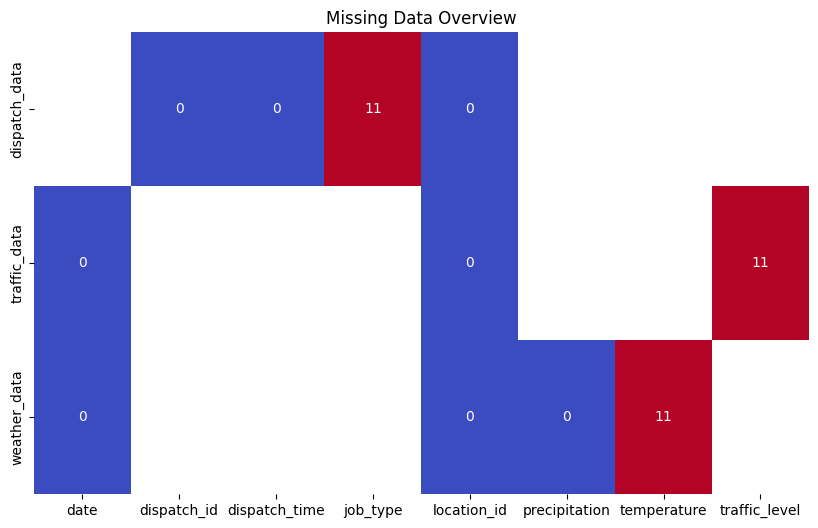

In [8]:
# Missing Data Visualization:

# Combine missing data info
missing_data = pd.DataFrame({
    "dispatch_data": dispatch_data.isnull().sum(),
    "traffic_data": traffic_data.isnull().sum(),
    "weather_data": weather_data.isnull().sum()
})
print("\nSummary of missing data:")
print(missing_data)

# Heatmap of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data.T, annot=True, cmap="coolwarm", cbar=False)
plt.title("Missing Data Overview")
plt.show()


# Clean up data issues


Cleaned dispatch_data:
   dispatch_id  location_id       job_type                 dispatch_time  \
0            1          106  fuel_delivery 2024-01-02 08:47:37.867155968   
1            2          106  fuel_delivery 2024-01-03 23:29:39.787000320   
2            3          112    tire_change 2024-01-03 11:09:58.744973312   
3            4          113   battery_jump 2024-01-01 12:23:25.783618048   
4            5          111        lockout 2024-01-01 15:50:39.269447424   

                completion_time  delay_minutes       date  source_dispatch  
0 2024-01-02 09:35:37.867155968           48.0 2024-01-02                1  
1 2024-01-03 23:49:39.787000320           20.0 2024-01-03                1  
2 2024-01-03 11:53:58.744973312           44.0 2024-01-03                1  
3 2024-01-01 12:38:25.783618048           15.0 2024-01-01                1  
4 2024-01-01 15:59:39.269447424            9.0 2024-01-01                1  
(500, 8)
dispatch_id                 int64
location_id   

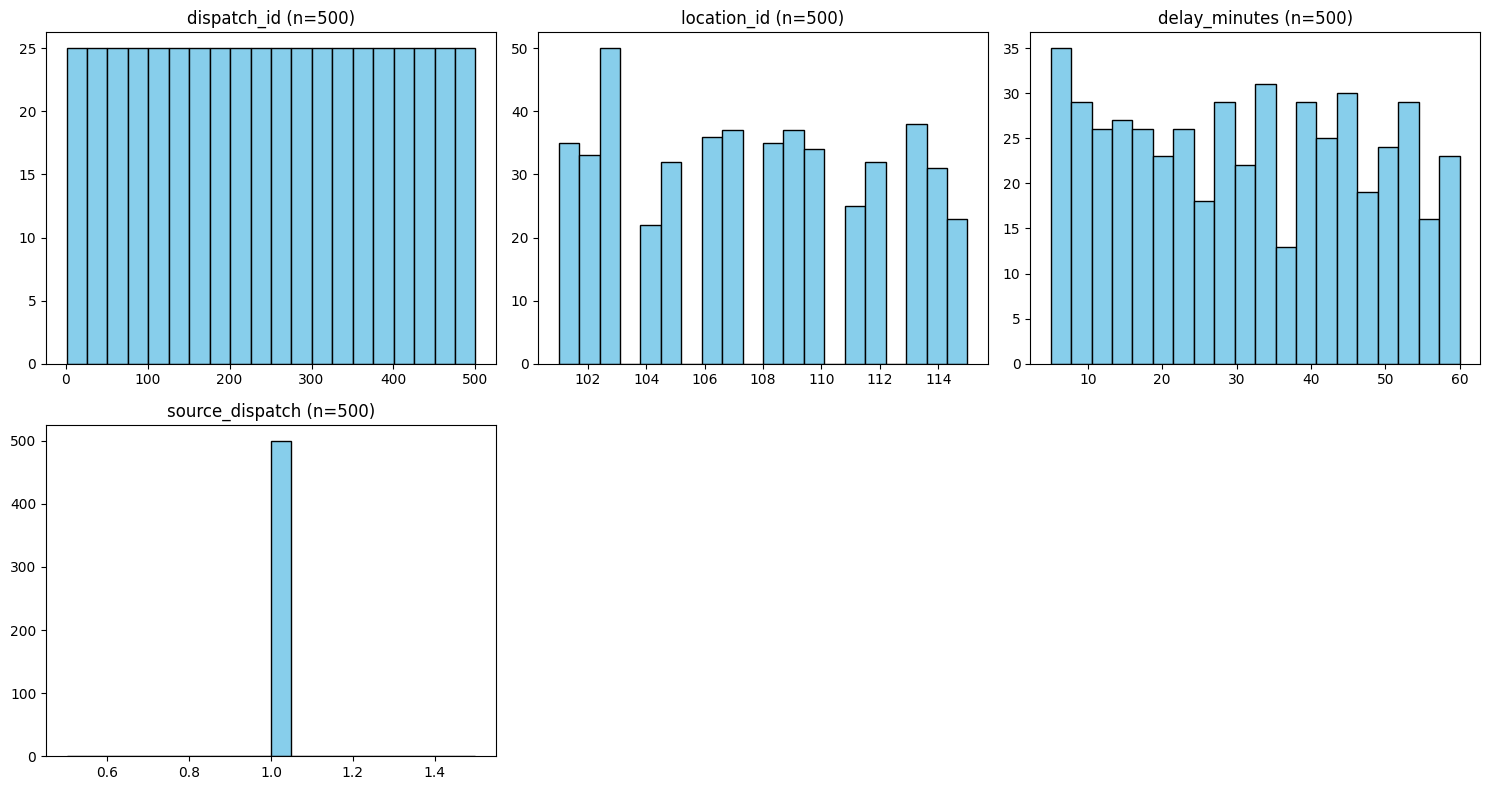

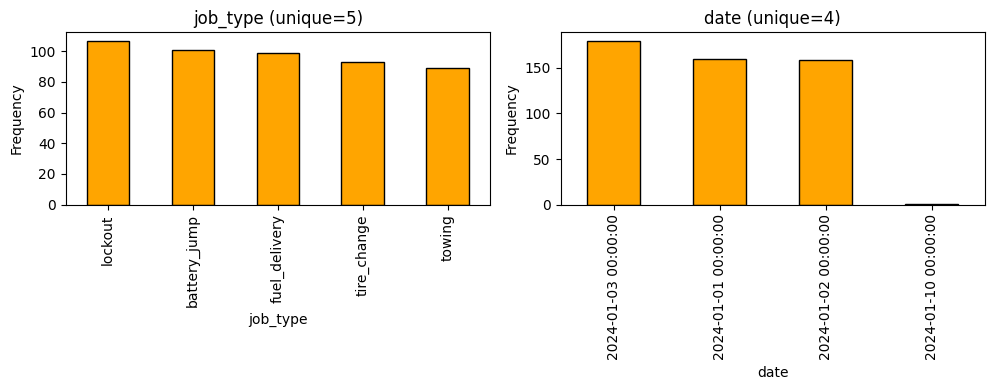

In [35]:
# Clean up Dispatch data

# Drop rows with invalid dispatch_time
dispatch_data['dispatch_time'] = pd.to_datetime(dispatch_data['dispatch_time'], errors='coerce')
placeholder_time = pd.Timestamp("2024-01-10 12:00:00")
dispatch_data['dispatch_time'].fillna(placeholder_time, inplace=True)

# Impute invalid location_id with a placeholder (e.g., 101)
dispatch_data.loc[~dispatch_data['location_id'].between(101, 116), 'location_id'] = 101

# Simulate a completion_time column
# Assuming completion time is 5 to 60 minutes after dispatch time
dispatch_data['completion_time'] = pd.to_datetime(dispatch_data['dispatch_time']) + pd.to_timedelta(
    np.random.randint(5, 61, size=len(dispatch_data)), unit='m'
)

# Calculate delay in minutes
dispatch_data['delay_minutes'] = (
    (dispatch_data['completion_time'] - pd.to_datetime(dispatch_data['dispatch_time'])).dt.total_seconds() / 60
)

# Extract date from dispatch_time
# Convert dispatch_time to datetime and extract the date while keeping datetime64[ns]
dispatch_data['date'] = pd.to_datetime(dispatch_data['dispatch_time']).dt.floor('d')

# View cleaned data
print("\nCleaned dispatch_data:")
print(dispatch_data.head())
print(dispatch_data.shape)
print(dispatch_data.dtypes)

# Visualizations
plot_histogram(dispatch_data)
plot_bar(dispatch_data)

    location_id       date  dupes
0           101 2024-01-01      1
1           101 2024-01-02      1
32          109 2024-01-01      1
33          109 2024-01-02      1
34          109 2024-01-03      1
35          109 2024-01-04      1
36          110 2024-01-01      1
37          110 2024-01-02      1
38          110 2024-01-03      1
39          110 2024-01-04      1
40          111 2024-01-01      1
41          111 2024-01-02      1
42          111 2024-01-03      1
43          111 2024-01-04      1
44          112 2024-01-01      1
45          112 2024-01-02      1
46          112 2024-01-03      1
47          112 2024-01-04      1
48          113 2024-01-01      1
49          113 2024-01-02      1
50          113 2024-01-03      1
51          113 2024-01-04      1
52          114 2024-01-01      1
53          114 2024-01-02      1
54          114 2024-01-03      1
55          114 2024-01-04      1
56          115 2024-01-01      1
57          115 2024-01-02      1
58          11

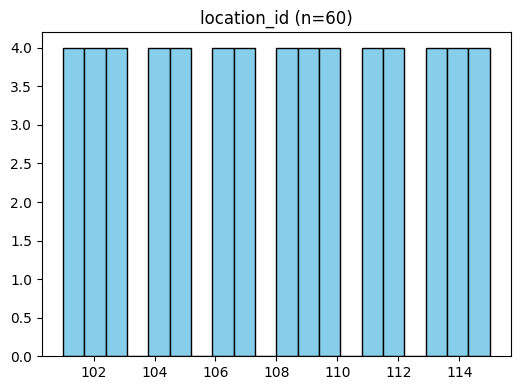

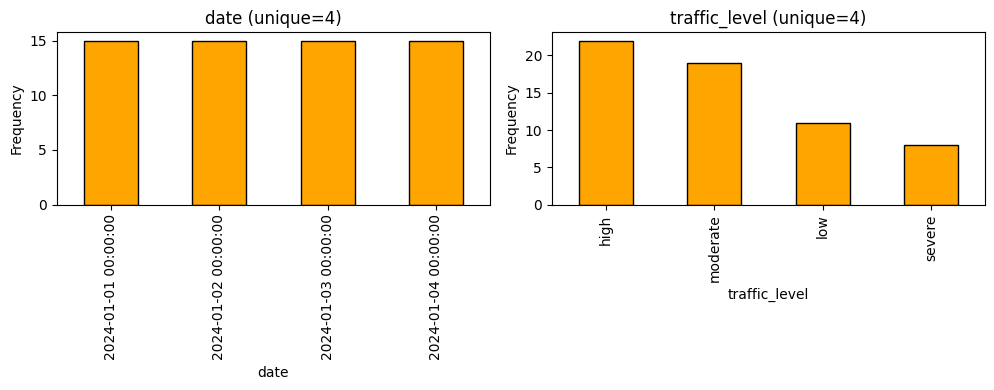

In [33]:
# Clean up Traffic Data

# Convert invalid dates to NaT and drop them
traffic_data['date'] = pd.to_datetime(traffic_data['date'], errors='coerce')
traffic_data.dropna(subset=['date'], inplace=True)

# Replace invalid location_id with a valid random one between 101 and 116
traffic_data.loc[~traffic_data['location_id'].between(101, 116), 'location_id'] = np.random.choice(range(101, 117))

# Impute missing traffic levels with 'moderate'
traffic_data['traffic_level'].fillna('moderate', inplace=True)

# Diagnose multi-valued location-days
print(
    traffic_data.groupby(['location_id', 'date']).size()
    .reset_index(name='dupes')
    .sort_values('dupes', ascending=False)
)

# Consolidate multiple values per location-day to a single mode
traffic_data = (
    traffic_data.groupby(['location_id', 'date'])['traffic_level']
    .agg(lambda x: x.mode().iloc[0])
    .reset_index()
)

# Confirm uniqueness
max_dupe = (traffic_data.groupby(['location_id', 'date']).size()
            .reset_index(name='dupe_check')['dupe_check'].max())
print("Max duplication after consolidation:", max_dupe)

# Preview cleaned data
print("\nCleaned traffic_data:")
print(traffic_data.head())
print("Shape:", traffic_data.shape)
print(traffic_data.dtypes)


# Visualizations
plot_histogram(traffic_data)
plot_bar(traffic_data)

    location_id       date  dupes
0           101 2024-01-01      1
1           101 2024-01-02      1
52          118 2024-01-02      1
51          118 2024-01-01      1
50          117 2024-01-03      1
..          ...        ...    ...
23          108 2024-01-03      1
22          108 2024-01-02      1
21          108 2024-01-01      1
20          107 2024-01-03      1
71          124 2024-01-03      1

[72 rows x 3 columns]

Cleaned weather_data:
   location_id       date  temperature  precipitation
0          101 2024-01-01         86.3           0.02
1          101 2024-01-02         62.8           0.50
2          101 2024-01-03         65.3           0.15
3          102 2024-01-01         68.3           0.71
4          102 2024-01-02         77.9           0.19
location_id               int64
date             datetime64[ns]
temperature             float64
precipitation           float64
dtype: object


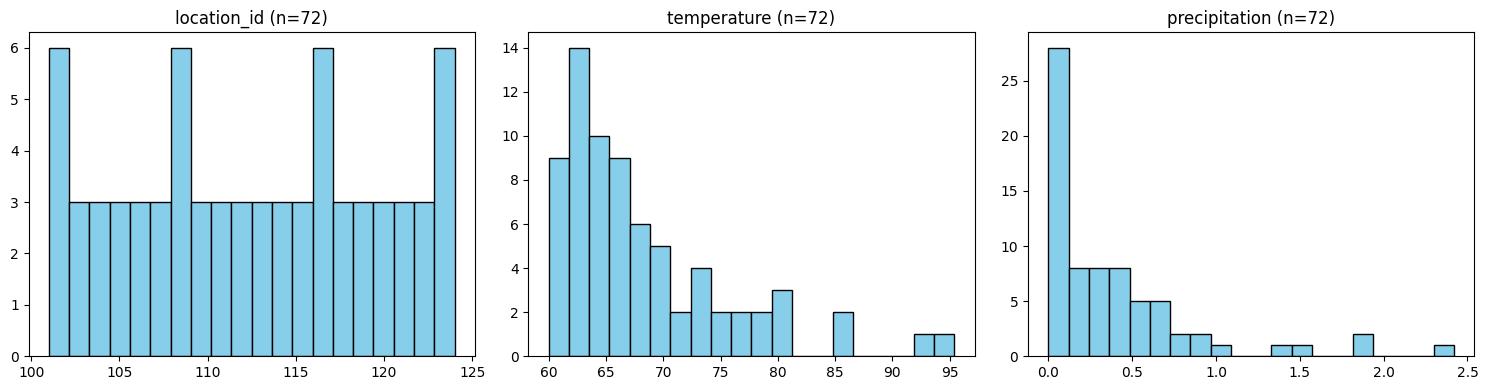

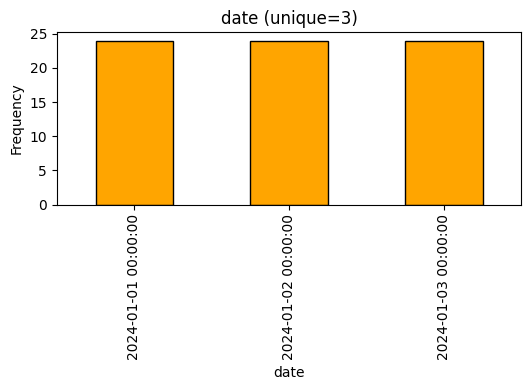

In [34]:
# Clean up Weather data

# Drop rows with invalid dates
weather_data['date'] = pd.to_datetime(weather_data['date'], errors='coerce')
weather_data = weather_data.dropna(subset=['date'])

# Replace invalid precipitation with 0
weather_data.loc[weather_data['precipitation'] < 0, 'precipitation'] = 0

# Impute missing temperatures with the column mean
weather_data['temperature'].fillna(weather_data['temperature'].mean(), inplace=True)

# Are there multiple weather values per location-day?
print(weather_data.groupby(['location_id', 'date']).size().reset_index(name = 'dupes').sort_values('dupes', ascending = False))
# A: Yes

# Enforce a single value per location-day
weather_data = (
    weather_data.groupby(['location_id', 'date'])
    # These fancy functions for mode are to get around the case where there's multiple modes per group - which would return a series and cause issues in the results,
    .agg(temperature=('temperature', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
         precipitation=('precipitation', lambda x: x.mode().iloc[0] if not x.mode().empty else None))
    .reset_index()
)

# Validate uniqueness, should get 1 as a result
weather_data.groupby(['location_id', 'date']).size().reset_index(name = 'dupe_check')['dupe_check'].max() 

# Preview cleaned data
print("\nCleaned weather_data:")
print(weather_data.head())
print(weather_data.dtypes)


# Visualizations
plot_histogram(weather_data)
plot_bar(weather_data)

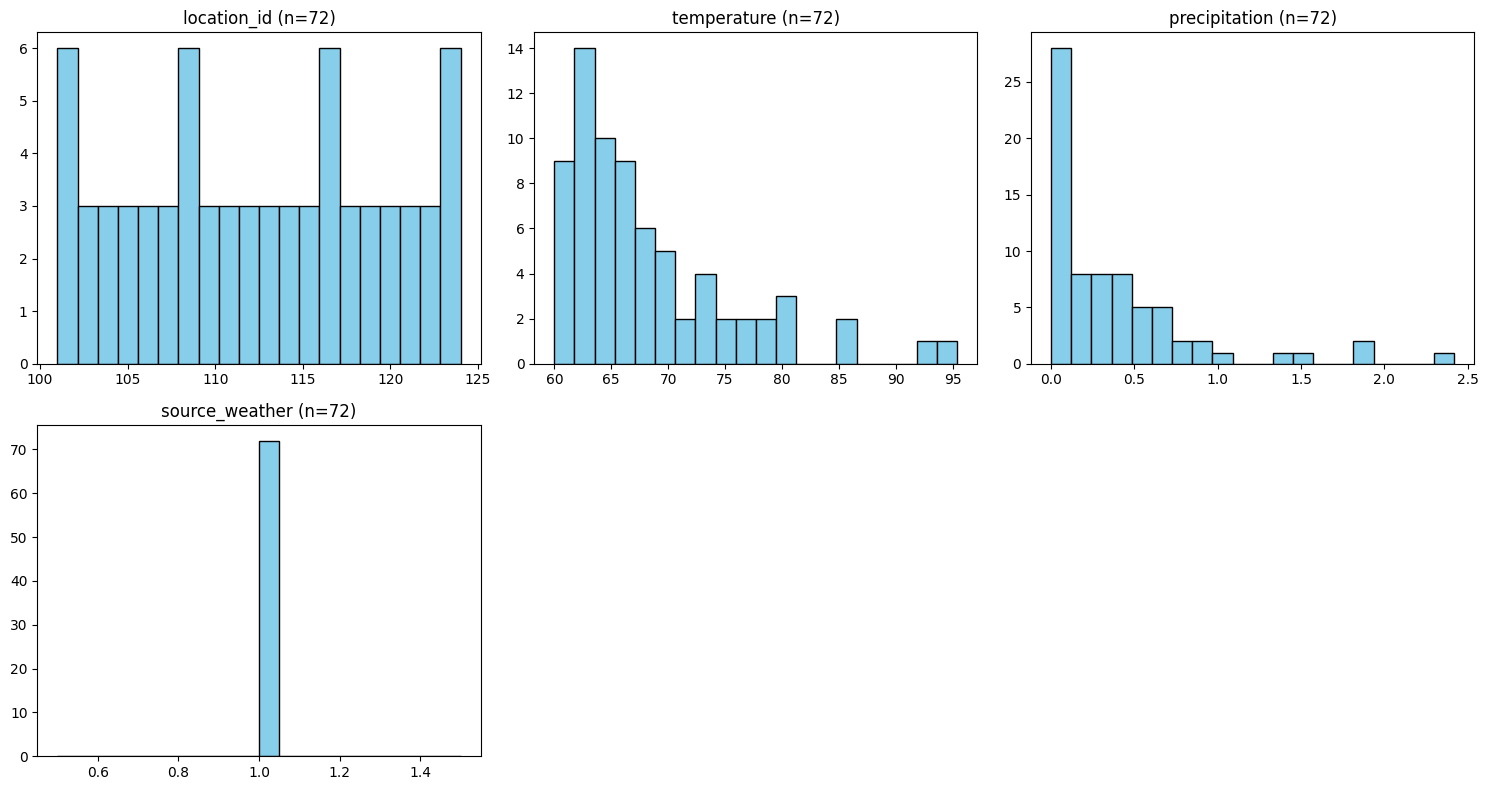

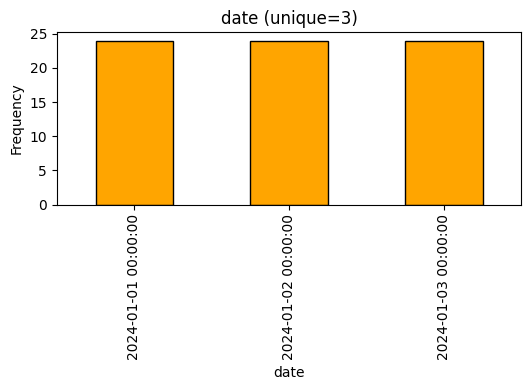

# Visualize cleaned data

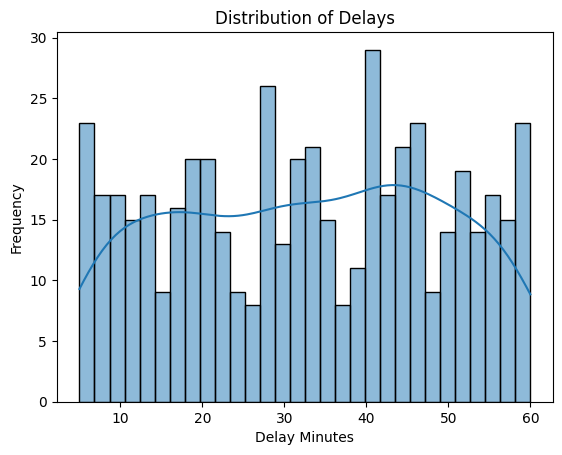

In [13]:
# EDA: Distribution of delays
sns.histplot(dispatch_data['delay_minutes'], kde=True, bins=30)
plt.title('Distribution of Delays')
plt.xlabel('Delay Minutes')
plt.ylabel('Frequency')
plt.show()

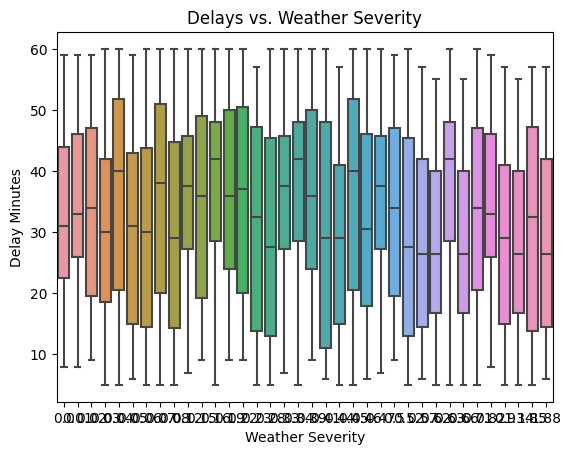

In [14]:
# EDA: Plot delays against weather severity
merged_data = pd.merge(dispatch_data, weather_data, on='location_id', how='left')
sns.boxplot(data=merged_data, x='precipitation', y='delay_minutes')
plt.title('Delays vs. Weather Severity')
plt.xlabel('Weather Severity')
plt.ylabel('Delay Minutes')
plt.show()

# Unfortunately, since our data is random here, this is basically just all noise.

# Dataset Merging and EDA/Validate post-merge & filtering

In [15]:
# Add source flags
dispatch_data['source_dispatch'] = 1
traffic_data['source_traffic'] = 1
weather_data['source_weather'] = 1


In [16]:
# How unique is a location-day in the dispatch data?
dispatch_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False).head()

,location_id,date,rows
8,103,2024-01-03,19
18,107,2024-01-01,18
17,106,2024-01-03,16
2,101,2024-01-03,16
6,103,2024-01-01,16


In [17]:
# How unique is a location-day in the traffic data?
traffic_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False).head()

,location_id,date,rows
0,101,2024-01-01,1
1,101,2024-01-02,1
32,109,2024-01-01,1
33,109,2024-01-02,1
34,109,2024-01-03,1


In [18]:
# How unique is a location-day in the weather data?
weather_data.groupby(['location_id', 'date']).agg(rows = ('date', 'size')).reset_index().sort_values('rows', ascending = False).head()

,location_id,date,rows
0,101,2024-01-01,1
1,101,2024-01-02,1
52,118,2024-01-02,1
51,118,2024-01-01,1
50,117,2024-01-03,1


## Show how to analyze a full join. This type of analysis is not necessary for this project, but this is shown for completeness of analysis.

In [19]:
# Merge datasets with outer join to include all rows
merged_data = pd.merge(dispatch_data, traffic_data, on=['location_id', 'date'], how='outer')
merged_data = pd.merge(merged_data, weather_data, on=['location_id', 'date'], how='outer')

# Fill missing flags with 0 (indicating no match from that table)
merged_data['source_dispatch'] = merged_data['source_dispatch'].fillna(0).astype(int)
merged_data['source_traffic'] = merged_data['source_traffic'].fillna(0).astype(int)
merged_data['source_weather'] = merged_data['source_weather'].fillna(0).astype(int)



In [20]:
# Find only the intersection of all 3 datasets
merged_all_three = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 1)
]

percent_all_three = len(merged_all_three) / len(merged_data) * 100
print(f"Percentage of rows that merged across all three datasets: {percent_all_three:.2f}%")

Percentage of rows that merged across all three datasets: 92.07%


In [21]:
# View the full-joined data
merged_data

,dispatch_id,location_id,job_type,dispatch_time,completion_time,delay_minutes,date,source_dispatch,traffic_level,source_traffic,temperature,precipitation,source_weather
0,1.0,106,fuel_delivery,2024-01-02 08:47:37.867155968,2024-01-02 08:52:37.867155968,5.0,2024-01-02,1,high,1,64.8,0.23,1
1,21.0,106,NaN,2024-01-02 02:03:59.099144448,2024-01-02 02:51:59.099144448,48.0,2024-01-02,1,high,1,64.8,0.23,1
2,48.0,106,lockout,2024-01-02 07:31:22.194818816,2024-01-02 07:42:22.194818816,11.0,2024-01-02,1,high,1,64.8,0.23,1
3,229.0,106,towing,2024-01-02 11:06:20.581702912,2024-01-02 11:13:20.581702912,7.0,2024-01-02,1,high,1,64.8,0.23,1
4,288.0,106,tire_change,2024-01-02 20:54:30.782547968,2024-01-02 21:37:30.782547968,43.0,2024-01-02,1,high,1,64.8,0.23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,NaN,123,NaN,NaT,NaT,NaN,2024-01-02,0,NaN,0,73.4,0.90,1
538,NaN,123,NaN,NaT,NaT,NaN,2024-01-03,0,NaN,0,73.7,0.20,1
539,NaN,124,NaN,NaT,NaT,NaN,2024-01-01,0,NaN,0,61.2,1.54,1
540,NaN,124,NaN,NaT,NaT,NaN,2024-01-02,0,NaN,0,75.4,0.07,1


In [22]:
# Rows only in dispatch_data
only_dispatch = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 0)
]
percent_only_dispatch = len(only_dispatch) / len(dispatch_data) * 100

# Rows only in traffic_data
only_traffic = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 0)
]
percent_only_traffic = len(only_traffic) / len(traffic_data) * 100

# Rows only in weather_data
only_weather = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 1)
]
percent_only_weather = len(only_weather) / len(weather_data) * 100

# Dispatch x Traffic only
dispatch_and_traffic = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 0)
]

# Dispatch x Weather only
dispatch_and_weather = merged_data[
    (merged_data['source_dispatch'] == 1) &
    (merged_data['source_traffic'] == 0) &
    (merged_data['source_weather'] == 1)
]

# Traffic x Weather only
traffic_and_weather = merged_data[
    (merged_data['source_dispatch'] == 0) &
    (merged_data['source_traffic'] == 1) &
    (merged_data['source_weather'] == 1)
]


In [23]:
# Total rows in merged_data
total_rows = len(merged_data)

# Percentages
percent_all_three = len(merged_all_three) / total_rows * 100
percent_only_dispatch = len(only_dispatch) / len(dispatch_data) * 100
percent_only_traffic = len(only_traffic) / len(traffic_data) * 100
percent_only_weather = len(only_weather) / len(weather_data) * 100

print(f"Percentage of rows that merged across all three datasets: {percent_all_three:.2f}%")
print(f"Percentage of rows only in dispatch_data: {percent_only_dispatch:.2f}%")
print(f"Percentage of rows only in traffic_data: {percent_only_traffic:.2f}%")
print(f"Percentage of rows only in weather_data: {percent_only_weather:.2f}%")


Percentage of rows that merged across all three datasets: 92.07%
Percentage of rows only in dispatch_data: 0.20%
Percentage of rows only in traffic_data: 25.00%
Percentage of rows only in weather_data: 37.50%


In [24]:
print(dispatch_data.shape)
print(traffic_data.shape)
print(weather_data.shape)
merged_data

(500, 8)
(60, 4)
(72, 5)


,dispatch_id,location_id,job_type,dispatch_time,completion_time,delay_minutes,date,source_dispatch,traffic_level,source_traffic,temperature,precipitation,source_weather
0,1.0,106,fuel_delivery,2024-01-02 08:47:37.867155968,2024-01-02 08:52:37.867155968,5.0,2024-01-02,1,high,1,64.8,0.23,1
1,21.0,106,NaN,2024-01-02 02:03:59.099144448,2024-01-02 02:51:59.099144448,48.0,2024-01-02,1,high,1,64.8,0.23,1
2,48.0,106,lockout,2024-01-02 07:31:22.194818816,2024-01-02 07:42:22.194818816,11.0,2024-01-02,1,high,1,64.8,0.23,1
3,229.0,106,towing,2024-01-02 11:06:20.581702912,2024-01-02 11:13:20.581702912,7.0,2024-01-02,1,high,1,64.8,0.23,1
4,288.0,106,tire_change,2024-01-02 20:54:30.782547968,2024-01-02 21:37:30.782547968,43.0,2024-01-02,1,high,1,64.8,0.23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,NaN,123,NaN,NaT,NaT,NaN,2024-01-02,0,NaN,0,73.4,0.90,1
538,NaN,123,NaN,NaT,NaT,NaN,2024-01-03,0,NaN,0,73.7,0.20,1
539,NaN,124,NaN,NaT,NaT,NaN,2024-01-01,0,NaN,0,61.2,1.54,1
540,NaN,124,NaN,NaT,NaT,NaN,2024-01-02,0,NaN,0,75.4,0.07,1


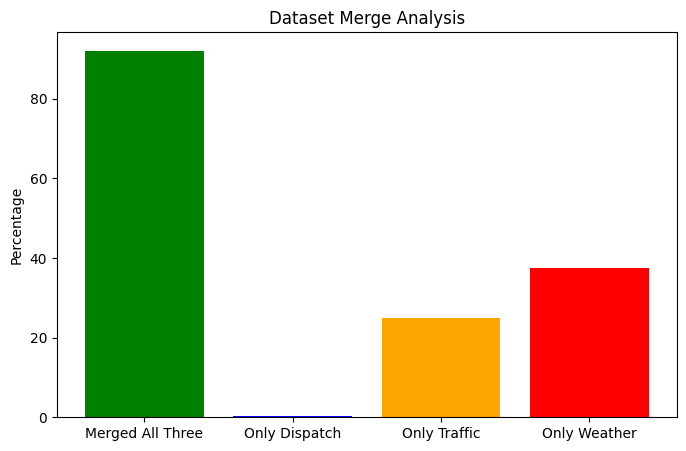

In [25]:
# Data for visualization
categories = ['Merged All Three', 'Only Dispatch', 'Only Traffic', 'Only Weather']
values = [percent_all_three, percent_only_dispatch, percent_only_traffic, percent_only_weather]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['green', 'blue', 'orange', 'red'])
plt.ylabel('Percentage')
plt.title('Dataset Merge Analysis')
plt.show()


In [26]:
# Total rows classified
total_rows_accounted_for = (
    len(merged_all_three) +
    len(only_dispatch) +
    len(only_traffic) +
    len(only_weather) +
    len(dispatch_and_traffic) +
    len(dispatch_and_weather) +
    len(traffic_and_weather)
)

# Compare with merged_data
print(f"Total rows accounted for: {total_rows_accounted_for}")
print(f"Total rows in merged_data: {len(merged_data)}")


Total rows accounted for: 542
Total rows in merged_data: 542


## Dispatch data left joining in traffic and weather for modeling

In [27]:
# Merge datasets with outer join to include all rows
left_merged_data = pd.merge(dispatch_data, traffic_data, on=['location_id', 'date'], how='left')
left_merged_data = pd.merge(left_merged_data, weather_data, on=['location_id', 'date'], how='left')

# Fill missing flags with 0 (indicating no match from that table)
left_merged_data['source_dispatch'] = left_merged_data['source_dispatch'].fillna(0).astype(int)
left_merged_data['source_traffic'] = left_merged_data['source_traffic'].fillna(0).astype(int)
left_merged_data['source_weather'] = left_merged_data['source_weather'].fillna(0).astype(int)

left_merged_data.head()

,dispatch_id,location_id,job_type,dispatch_time,completion_time,delay_minutes,date,source_dispatch,traffic_level,source_traffic,temperature,precipitation,source_weather
0,1,106,fuel_delivery,2024-01-02 08:47:37.867155968,2024-01-02 08:52:37.867155968,5.0,2024-01-02,1,high,1,64.8,0.23,1
1,2,106,fuel_delivery,2024-01-03 23:29:39.787000320,2024-01-03 23:41:39.787000320,12.0,2024-01-03,1,low,1,61.4,0.06,1
2,3,112,tire_change,2024-01-03 11:09:58.744973312,2024-01-03 11:37:58.744973312,28.0,2024-01-03,1,moderate,1,61.2,0.66,1
3,4,113,battery_jump,2024-01-01 12:23:25.783618048,2024-01-01 13:22:25.783618048,59.0,2024-01-01,1,high,1,62.3,0.45,1
4,5,111,lockout,2024-01-01 15:50:39.269447424,2024-01-01 16:47:39.269447424,57.0,2024-01-01,1,high,1,67.5,0.05,1


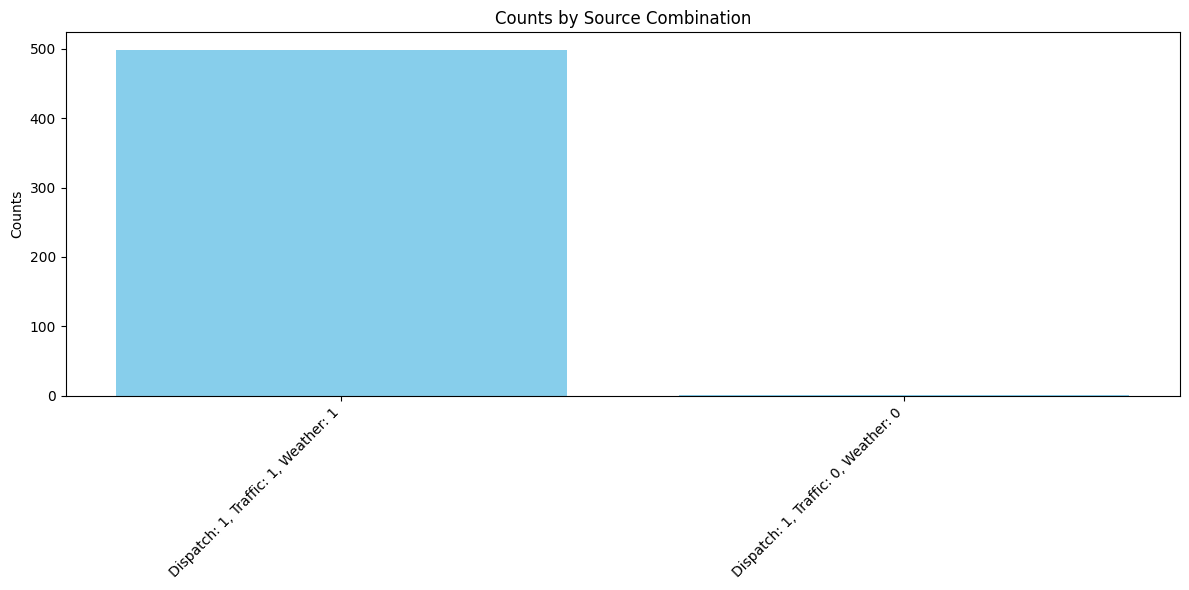

In [28]:
# Plot bar chart of these intersections
source_counts = left_merged_data.groupby(['source_dispatch', 'source_traffic', 'source_weather']).size().reset_index(name = 'counts').sort_values('counts', ascending = False)

source_counts['source_label'] = (
    "Dispatch: " + source_counts['source_dispatch'].astype(str) + 
    ", Traffic: " + source_counts['source_traffic'].astype(str) + 
    ", Weather: " + source_counts['source_weather'].astype(str)
)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(source_counts['source_label'], source_counts['counts'], color='skyblue')

# Customize the plot
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Counts')
plt.title('Counts by Source Combination')
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
# Unique keys in each dataset
dispatch_keys = dispatch_data[['location_id', 'date']].drop_duplicates()
traffic_keys = traffic_data[['location_id', 'date']].drop_duplicates()
weather_keys = weather_data[['location_id', 'date']].drop_duplicates()

# Keys not matched in traffic
missing_in_traffic = dispatch_keys.merge(traffic_keys, on=['location_id','date'], how='left', indicator=True)
missing_in_traffic = missing_in_traffic[missing_in_traffic['_merge'] == 'left_only']

print("Rows in dispatch_data that are missing in traffic_data:")
print(missing_in_traffic.head())
print(f"Count missing: {len(missing_in_traffic)}")

# Keys not matched in weather
missing_in_weather = dispatch_keys.merge(weather_keys, on=['location_id','date'], how='left', indicator=True)
missing_in_weather = missing_in_weather[missing_in_weather['_merge'] == 'left_only']

print("Rows in dispatch_data that are missing in weather_data:")
print(missing_in_weather.head())
print(f"Count missing: {len(missing_in_weather)}")


Rows in dispatch_data that are missing in traffic_data:
    location_id       date     _merge
25          109 2024-01-10  left_only
Count missing: 1
Rows in dispatch_data that are missing in weather_data:
    location_id       date     _merge
25          109 2024-01-10  left_only
Count missing: 1


In [30]:
print("Row count in final merged data:", len(left_merged_data))

nan_summary = left_merged_data[['traffic_level', 'temperature', 'precipitation']].isnull().sum()
print(nan_summary)


Row count in final merged data: 500
traffic_level    1
temperature      1
precipitation    1
dtype: int64


# Export for later

In [31]:
# Save cleaned data for further analysis
dispatch_data.to_csv('data/cleaned_dispatch_data.csv', index=False)
traffic_data.to_csv('data/cleaned_traffic_data.csv', index=False)
weather_data.to_csv('data/cleaned_weather_data.csv', index=False)
left_merged_data.to_csv('data/left_merged_data.csv', index=False)
